# Malware Analysis of ELF Files using Machine Learning

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!python3 -m pip install pyelftools

## About ELF Files

The information of ELF Files is contained in three primary sections:
+ File Header
+ Program Header
+ Section Information

An ELF File contains one File Header, one Program Header and many Sections.

In [3]:
# Constants
EMPTY_SECTION_NAME_SUBSTITUTE = "S"
FILE_NAME_COLUMN_NAME = "FileName"
FILE_TYPE_COLUMN_NAME = 'FileType'
NUMERIC_COLUMN_IDENTIFIER = "N"
MALWARE_SECTION_NAME_PREFIX = "M"

BENIGN_FILE = 0
BACKDOOR_FILE = 1
BOTNET_FILE = 2
DDOS_FILE = 3
TROJAN_FILE = 4
VIRUS_FILE = 5

In [4]:
import glob

def extractInformationFromADirectory(inputDirectory):
    # Declare Counters
    numberOfValidFiles = 0
    numberOfInvalidFiles = 0
    numberOfFilesWithNoFileHeader = 0
    numberOfFilesWithNoProgramHeader = 0
    numberOfFilesWithNoSections = 0

    # Create an Empty List to hold all the features of all the files
    returnValue = []
    
    # Loop through all the files in the Input Directory
    for file in glob.glob(inputDirectory):
        # Create an empty Dictionary
        oneFileFeatures = {}
        
        try:
            # Read the file and extract the features
            fileFeatures, validFlag, hasFileHeader, hasProgramHeader, hasSections = ExtractFileDetails(file)
            if(validFlag and len(fileFeatures.keys()) > 0):
                numberOfValidFiles += 1

                # Add the File Features to the main Dictionary
                oneFileFeatures.update(fileFeatures)
            
                # Add the entry to the return value
                returnValue.append(oneFileFeatures)
            else:
                if hasFileHeader == False:
                    numberOfFilesWithNoFileHeader += 1
                else:
                    if hasProgramHeader == False:
                        numberOfFilesWithNoProgramHeader += 1
                    else:
                        if hasSections == False:
                            numberOfFilesWithNoSections += 1
                        else:
                            numberOfInvalidFiles += 1
            
        except:
            # Check if the file is a valid ELF File
            if isELFFile(file):
                pass
            else:
                numberOfInvalidFiles += 1

    return (returnValue, 
            numberOfValidFiles, 
            numberOfInvalidFiles, 
            numberOfFilesWithNoFileHeader, 
            numberOfFilesWithNoProgramHeader, 
            numberOfFilesWithNoSections)

In [5]:
def ExtractFileDetails(file):
    ''' Function Name: ExtractFileDetails
        Purpose: To extract the details of all the information of an ELF File.
                 The information in an ELF File is stored as File Header, Program Header and Section Information.
                 There is one set of information for File Header and Program Header.
                 However, there can be many sections in an ELF File.
        Input Parameters:
            1. file: A File from which the information needs to be extracted.
                     The file may be a valid ELF File or not a valid ELF File.
        Output Parameters:
            1. A Dictionary containing the attributes as the key and their values as the value.
               In case, no information can be extracted from the ELF File or the file is not a valid ELF File, an empty dictionary is returned.
            2. Boolean value indication whether the provided file was a valid ELF File or not.
               True if the provided file was an ELF File, False otherwise.
    '''
    returnValue = {}
    validELFFile = True
    hasFileHeader = True
    hasProgramHeader = True
    hasSections = True
    
    try:
        with open(file, 'rb') as elffile:
            try:
                eFile = ELFFile(elffile)

                # Extract the File Header Information
                fileHeader = ExtractFileHeader(eFile)
                if(len(fileHeader) > 0):
                    returnValue.update(fileHeader) # Add the attributes to dictionary
                else:
                    hasFileHeader = False
                    raise Exception()

                # Extract the Program Header Information
                segmentDetails = ExtractSegmentDetails(eFile)
                if(len(segmentDetails) > 0):
                    returnValue.update(segmentDetails) # Add the attributes to dictionary
                else:
                    hasProgramHeader = False
                    raise Exception()

                sectionDetails = ExtractSectionDetails(eFile)
                if(len(sectionDetails) > 0):
                    returnValue.update(sectionDetails) # Add the attributes to dictionary
                else:
                    hasSections = False
                    raise Exception()

            except:
                validELFFile = False

            finally:
                elffile.close()
    except:
        pass
    
    return (returnValue, validELFFile, hasFileHeader, hasProgramHeader, hasSections)

In [6]:
from elftools.elf.elffile import ELFFile

def ExtractFileHeader(elffile):
    ''' Function Name: ExtractFileHeader
        Purpose: To extract the File Header of the ELF File.
        Input Parameters:
            1. elffile: A valid ELF File from which the Segment information has to be extracted
        Output Parameters:
            1. A Dictionary containing the attributes as the key and their values as the value
               In case, the ELF File has no File Header, an empty dictionary is returned (This is not possible for valid ELF Files)
    '''
    returnValue = {} # Dictionary to hold the unique attributes the header
    
    # The header information can be obtained as a dictionary.
    # However, there are some dictionaries inside this dictionary.
    # So, we create a flat structure taking out all the unique attributes and form a dictionary.
    for key, value in elffile.header.items():
        # If the value for the key is a dictionary, then loop through all the attributes of this dictionary to collect the features.
        # The approach is simplistic as I do not go for a recursive function as it is known that there can be only one additional level of dictionary.
        if key == "e_ident":
            for insideKey, insideValue in value.items():
                if insideKey == "EI_MAG":
                    pass
                else:
                    returnValue[insideKey] = insideValue
        else:
            returnValue[key] = value
    
    return returnValue

In [7]:
from elftools.elf.elffile import ELFFile

def ExtractSegmentDetails(elffile):
    ''' Function Name: ExtractSegmentDetails
        Purpose: To extract the details of all the segments in the ELF File.
                 The segment information is the Program Header of a ELF File.
        Input Parameters:
            1. elffile: A valid ELF File from which the Segment information has to be extracted
        Output Parameters:
            1. A Dictionary containing the attributes as the key and their values as the value
               In case, the ELF File has no segments, an empty dictionary is returned (This is not possible for valid ELF Files)
    '''
    returnValue = {} # Dictionary to hold the unique attributes of all the segments

    # Check if any segment information exists in the file
    # If it does, collect all the information of all the attributes in all the segments
    if(elffile.num_segments() > 0):
        prefixDict = {} # Dictionary to hold the unique segment attributes for all the segment names

        # Each ELF File may have one or more number of segments
        # Loop through all the segments
        for segment in elffile.iter_segments():
            prefix = ""
            
            # In each segment, there can be one or more number of attributes
            # The attribute "p_type" contains the segment name
            # Under each segment, the attributes may be different from the other segments
            for attribute in segment.header:
                # The segment name is stored in the attribute "p_type"
                # So, we prefix the segment name to all the other attributes to uniquely identify each attribute for all the segments
                if(attribute == 'p_type'):
                    ctr = 0
                    prefix = segment.header[attribute]
                    # Here we check if 2 or more segments have the same name
                    # If there are 2 or more segments with the same name,
                    # then each of the segments is uniquely identified by adding a running counter to the end of the segment name
                    while True:
                        if prefix in prefixDict:
                            ctr += 1
                            prefix = (segment.header[attribute] + "-" + str(ctr))
                        else:
                            break
                            
                    prefixDict[prefix] = 1 # Keep a note of the segments processed so far
                else:
                    # Create a key as the "<segment name>-<attribute name>"
                    # And add it to the unique list of attributes
                    key = prefix + "-" + attribute
                    returnValue[key] = segment.header[attribute]
    
    return returnValue

In [8]:
from elftools.elf.elffile import ELFFile

def ExtractSectionDetails(elffile):
    ''' Function Name: ExtractSegmentDetails
        Purpose: To extract the details of all the segments in the ELF File.
                 The segment information is the Program Header of an ELF File.
        Input Parameters:
            1. elffile: A valid ELF File from which the Segment information has to be extracted
        Output Parameters:
            1. A Dictionary containing the attributes as the key and their values as the value
               In case, the ELF File has no segments, an empty dictionary is returned (This is not possible for valid ELF Files)
    '''
    returnValue = {}
    
    # ELF Files with malware contain Section Names which have been tampered.
    # If such a Section Name is found, then we store the tampered Section Name as a feature.
    # To be able to store these in unique attributes, we set a counter across the file.
    malwareSectionNameCounter = 0
    
    # Check if any section information exists in the file
    # If it does, collect all the information of all the attributes in all the sections
    if(elffile.num_sections() > 0):
        # Iterate through all the sections and gather the attributes.
        for section in elffile.iter_sections():
            # Every section has a name.
            # Section Name has to be a valid ASCII string.
            # If the Section Name contains non-ASCII characters, then the file has been tampered.
            if all((ord(char) > 32 and ord(char) < 128) for char in section.name):
                sectionName = section.name
            else:
                # In case the Section Name contains non-ASCII characters, we store the Section Name as a feature in our data set
                malwareSectionNameCounter = malwareSectionNameCounter + 1
                sectionName = MALWARE_SECTION_NAME_PREFIX + str(malwareSectionNameCounter)
                returnValue[sectionName] = section.name
                
            # Attributes of all the sections may have the same name.
            # So, section name will be prefixed to the attribute name to form the key for the dictionary.
            sectionName = sectionName.lstrip('.') # Remove leading dot ('.') from the section name
            sectionName = sectionName.lstrip('_') # Remove leading underscores ('_') from the section name
            sectionName = sectionName.replace('.', '-') # Remove all the dots ('.') and replace with a dash ('-')
            sectionName = sectionName.strip()

            if len(sectionName) == 0:
                sectionName = EMPTY_SECTION_NAME_SUBSTITUTE
            
            # Every section has a header.
            # Iterate through all the attributes in the header of the section.
            # The attributes of the section header are prefixed by the section name to form the attribute name.
            for key, value in section.header.items():
                attributeName = sectionName + "-" + key
                returnValue[attributeName] = value
    
    return returnValue

### Function to check whether a file is an ELF File

In [9]:
from elftools.elf.elffile import ELFFile

def isELFFile(file):
    ''' Function Name: isELFFile
        Purpose: To check whether a file is an ELF File
        Input Parameters:
            1. file: File to be checked
        Output Parameters:
            1. Boolean: True if File is an ELF File, False otherwise
    '''
    with open(file, 'rb') as elffile:
        returnValue = True
        
        try:
            ELFFile(elffile) # The constructor of the ELFFile class checks whether the magic number for an ELF File exists in the provided file
            
        except:
            returnValue = False
            
        finally:
            elffile.close()
        
    return returnValue

In [10]:
benignFileFeatures, nValidFiles, nInvalidFiles, nFilesWithNoFileHeader, nFilesWithNoProgramHeader, nFilesWithNoSections = \
                extractInformationFromADirectory("Data/benign_ELF/*")
print("BENIGN FILES:\nValid - %d\nInvalid - %d\nNo File Header - %d\nNo Program Header - %d\nNo Sections - %d" % \
      (nValidFiles, nInvalidFiles, nFilesWithNoFileHeader, nFilesWithNoProgramHeader, nFilesWithNoSections))

BENIGN FILES:
Valid - 2038
Invalid - 30
No File Header - 0
No Program Header - 0
No Sections - 10


In [11]:
backdoorFileFeatures, nValidFiles, nInvalidFiles, nFilesWithNoFileHeader, nFilesWithNoProgramHeader, nFilesWithNoSections = \
                extractInformationFromADirectory("Data/malware_ELF/Backdoor/*")
print("BACKDOOR FILES:\nValid - %d\nInvalid - %d\nNo File Header - %d\nNo Program Header - %d\nNo Sections - %d" % \
      (nValidFiles, nInvalidFiles, nFilesWithNoFileHeader, nFilesWithNoProgramHeader, nFilesWithNoSections))

BACKDOOR FILES:
Valid - 589
Invalid - 36
No File Header - 0
No Program Header - 1
No Sections - 50


In [12]:
botnetFileFeatures, nValidFiles, nInvalidFiles, nFilesWithNoFileHeader, nFilesWithNoProgramHeader, nFilesWithNoSections = \
                extractInformationFromADirectory("Data/malware_ELF/Botnet/*")
print("BOTNET FILES:\nValid - %d\nInvalid - %d\nNo File Header - %d\nNo Program Header - %d\nNo Sections - %d" % \
      (nValidFiles, nInvalidFiles, nFilesWithNoFileHeader, nFilesWithNoProgramHeader, nFilesWithNoSections))

BOTNET FILES:
Valid - 616
Invalid - 64
No File Header - 0
No Program Header - 0
No Sections - 33


In [13]:
ddosFileFeatures, nValidFiles, nInvalidFiles, nFilesWithNoFileHeader, nFilesWithNoProgramHeader, nFilesWithNoSections = \
                extractInformationFromADirectory("Data/malware_ELF/Ddos/*")
print("DDOS FILES:\nValid - %d\nInvalid - %d\nNo File Header - %d\nNo Program Header - %d\nNo Sections - %d" % \
      (nValidFiles, nInvalidFiles, nFilesWithNoFileHeader, nFilesWithNoProgramHeader, nFilesWithNoSections))

DDOS FILES:
Valid - 642
Invalid - 74
No File Header - 0
No Program Header - 0
No Sections - 9


In [14]:
trojanFileFeatures, nValidFiles, nInvalidFiles, nFilesWithNoFileHeader, nFilesWithNoProgramHeader, nFilesWithNoSections = \
                extractInformationFromADirectory("Data/malware_ELF/Trojan/*")
print("TROJAN FILES:\nValid - %d\nInvalid - %d\nNo File Header - %d\nNo Program Header - %d\nNo Sections - %d" % \
      (nValidFiles, nInvalidFiles, nFilesWithNoFileHeader, nFilesWithNoProgramHeader, nFilesWithNoSections))

TROJAN FILES:
Valid - 369
Invalid - 46
No File Header - 0
No Program Header - 0
No Sections - 46


In [15]:
virusFileFeatures, nValidFiles, nInvalidFiles, nFilesWithNoFileHeader, nFilesWithNoProgramHeader, nFilesWithNoSections = \
                extractInformationFromADirectory("Data/malware_ELF/Virus/*")
print("VIRUS FILES:\nValid - %d\nInvalid - %d\nNo File Header - %d\nNo Program Header - %d\nNo Sections - %d" % \
      (nValidFiles, nInvalidFiles, nFilesWithNoFileHeader, nFilesWithNoProgramHeader, nFilesWithNoSections))

VIRUS FILES:
Valid - 452
Invalid - 29
No File Header - 0
No Program Header - 0
No Sections - 58


### Extract the unique list of Keys for all the files
From the last 6 steps, we have 6 dictionaries containing all the attributes extracted from all the clean ELF files and from all the ELF files containing malware. In this step, a list of all the unique attributes is prepared. To do this, a set of tags is created. Set is chosen as sets cannot contain duplicate items.

The list of unique tags as extracted is listed below.

In [16]:
featureList = set()

for i in benignFileFeatures:
    for k in i.keys():
        if type(k) == int:
            featureList.add(NUMERIC_COLUMN_IDENTIFIER + str(k))
        else:
            featureList.add(k)

for i in backdoorFileFeatures:
    for k in i.keys():
        if type(k) == int:
            featureList.add(NUMERIC_COLUMN_IDENTIFIER + str(k))
        else:
            featureList.add(k)
            
for i in botnetFileFeatures:
    for k in i.keys():
        if type(k) == int:
            featureList.add(NUMERIC_COLUMN_IDENTIFIER + str(k))
        else:
            featureList.add(k)
            
for i in ddosFileFeatures:
    for k in i.keys():
        if type(k) == int:
            featureList.add(NUMERIC_COLUMN_IDENTIFIER + str(k))
        else:
            featureList.add(k)
            
for i in trojanFileFeatures:
    for k in i.keys():
        if type(k) == int:
            featureList.add(NUMERIC_COLUMN_IDENTIFIER + str(k))
        else:
            featureList.add(k)
            
for i in virusFileFeatures:
    for k in i.keys():
        if type(k) == int:
            featureList.add(NUMERIC_COLUMN_IDENTIFIER + str(k))
        else:
            featureList.add(k)

In [17]:
import pickle

pickle.dump(featureList, open("./FeatureList", 'wb'))

### Create a Dataframe containing all the Keys extracted in the previous step as Columns and fill in the values in the Dataframe

#### fillDataInDataFrame
Function to create a dataframe of all the attributes available in the set of ELF Files.

In [18]:
import pandas as pd

def fillDataInDataFrame(featureDictionary, p_featureList, fileType):
    # Create an Dummy variable to hold a DataFrame object
    df = None

    for record in featureDictionary:
        # Create an empty Dictionary
        oneRecord = {}

        # Initialize all the columns
        for colName in p_featureList:
            oneRecord[colName] = pd.to_numeric(0, downcast = 'integer')

        # Loop through all the features in a record
        for k in record.keys():
            # Extract the column name from the record
            if type(k) == int:
                extractedColumnName = NUMERIC_COLUMN_IDENTIFIER + str(k)
            else:
                extractedColumnName = k

            # Check if the column name exists in the feature list
            if extractedColumnName in p_featureList:
                # Extract the value for the key and store in the Dictionary
                if ((type(record[k]) == int) | (type(record[k]) == float)):
                    oneRecord[extractedColumnName] = pd.to_numeric(record[k], 
                                                                   downcast = 'integer')
                else:
                    oneRecord[extractedColumnName] = record[k]

        # Add column to mark Dependent Column as per the provided File Type
        oneRecord[FILE_TYPE_COLUMN_NAME] = pd.to_numeric(fileType, downcast = 'integer')
        
        # Add the Record to the Dataframe
        if df is None:
            df = pd.DataFrame([oneRecord], columns = oneRecord.keys())
        else:
            df = pd.concat([df, pd.DataFrame([oneRecord], columns = oneRecord.keys())],
                           ignore_index = True)

    return df

### Create a dataframe of attributes
In this step, 6 dataframes are created - 1 containing the attributes from clean ELF Files and 5 containing attributes from ELF Files containing malware.

In [19]:
benignFileDF = fillDataInDataFrame(benignFileFeatures, featureList, BENIGN_FILE)

In [20]:
backdoorFileDF = fillDataInDataFrame(backdoorFileFeatures, featureList, BACKDOOR_FILE)

In [21]:
botnetFileDF = fillDataInDataFrame(botnetFileFeatures, featureList, BOTNET_FILE)

In [22]:
ddosFileDF = fillDataInDataFrame(ddosFileFeatures, featureList, DDOS_FILE)

In [23]:
trojanFileDF = fillDataInDataFrame(trojanFileFeatures, featureList, TROJAN_FILE)

In [24]:
virusFileDF = fillDataInDataFrame(virusFileFeatures, featureList, VIRUS_FILE)

In [25]:
import pandas as pd

df = pd.concat([benignFileDF, 
                backdoorFileDF, 
                botnetFileDF, 
                ddosFileDF, 
                trojanFileDF, 
                virusFileDF], ignore_index=True)
df[FILE_TYPE_COLUMN_NAME] = pd.to_numeric(df[FILE_TYPE_COLUMN_NAME], 
                                          downcast = 'integer')

In [26]:
# Remove NULL character from all the Strings
for col in df.columns:
    if df[col].dtypes == 'object':
        df[col].replace(chr(0), '', inplace = True)

In [27]:
df[FILE_TYPE_COLUMN_NAME].value_counts()

0    2038
3     642
2     616
1     589
5     452
4     369
Name: FileType, dtype: int64

In [28]:
df.shape

(4706, 2540)

In [29]:
df.to_csv('./ELFDataSet.csv')

In [30]:
import numpy as np

dfNumeric = df.select_dtypes(include = [np.number])
dfNonNumeric = df.select_dtypes(exclude = [np.number])
print(dfNumeric.shape)
print(dfNonNumeric.shape)

(4706, 2274)
(4706, 266)


In [31]:
dfNonNumeric['ConcatenatedString'] = ""
for i in range(len(dfNonNumeric)):
    oneStr = ""
    for col in dfNonNumeric.columns:
        if type(dfNonNumeric[col][i]) == type("abc"):
            oneStr = oneStr + " " + dfNonNumeric[col][i]
        
    dfNonNumeric.loc[i, 'ConcatenatedString'] = oneStr

dfNonNumeric['ConcatenatedString'].head()

0     ELFDATA2LSB SHT_PROGBITS SHT_RELA ELFOSABI_SY...
1     ELFDATA2LSB SHT_PROGBITS SHT_PROGBITS ELFOSAB...
2     ELFDATA2LSB SHT_PROGBITS SHT_RELA ELFOSABI_SY...
3     ELFDATA2LSB SHT_PROGBITS SHT_RELA ELFOSABI_SY...
4     ELFDATA2LSB SHT_PROGBITS SHT_RELA ELFOSABI_SY...
Name: ConcatenatedString, dtype: object

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer 

tfidfconverter = TfidfVectorizer(max_features = 90000, ngram_range = (1,1)) 
arrNonNumericTFIDF = tfidfconverter.fit_transform(dfNonNumeric.ConcatenatedString).toarray()
dfNonNumericTFIDF = pd.DataFrame(arrNonNumericTFIDF, 
                                 columns = tfidfconverter.get_feature_names())
print(dfNonNumericTFIDF.shape)

(4706, 53)


In [33]:
import pandas as pd

dfForModel = pd.concat([dfNumeric, dfNonNumericTFIDF], axis = 1)

In [34]:
import pickle

print(dfForModel.shape)
pickle.dump(dfForModel, open("./XColumns", 'wb'))

(4706, 2327)


In [35]:
import imblearn as ib 

XTransform = dfForModel.drop([FILE_TYPE_COLUMN_NAME], axis = 1)
yTransform = dfForModel[FILE_TYPE_COLUMN_NAME]

# Transform the dataset 
oversample = ib.over_sampling.SMOTE(random_state = 42) 
XTrain, yTrain = oversample.fit_resample(XTransform, yTransform) 
print(XTrain.shape)
print(yTrain.value_counts())

(12228, 2326)
0    2038
1    2038
2    2038
3    2038
4    2038
5    2038
Name: FileType, dtype: int64


## Create the Random Forest Model

In [36]:
from sklearn.ensemble import RandomForestClassifier
import datetime
import pickle

print('Start Time: %s' % datetime.datetime.now())

# Create the Random Forest Model
modelRF = RandomForestClassifier(n_estimators = 1000, 
                                 criterion = "entropy", 
                                 oob_score = True)

modelRF.fit(XTrain, yTrain)
pickle.dump(modelRF, open("./RFModelELFMalwareDetection", 'wb'))

print('End Time: %s' % datetime.datetime.now())

Start Time: 2023-03-14 15:51:51.913994
End Time: 2023-03-14 15:52:45.981753





Accuracy of the Model: 0.9868334968923782


Classification Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2038
           1       0.98      1.00      0.99      2038
           2       1.00      0.98      0.99      2038
           3       1.00      1.00      1.00      2038
           4       0.96      0.98      0.97      2038
           5       0.99      0.96      0.98      2038

    accuracy                           0.99     12228
   macro avg       0.99      0.99      0.99     12228
weighted avg       0.99      0.99      0.99     12228



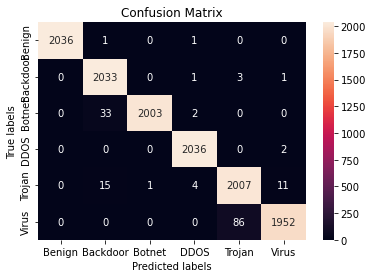

In [37]:
import matplotlib.pyplot as plt     
import seaborn as sns
from sklearn import metrics

y_pred = modelRF.predict(XTrain)

cm = metrics.confusion_matrix(yTrain, y_pred)

ax = plt.subplot()
sns.heatmap(cm, annot = True, fmt = 'g', ax = ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Benign', 'Backdoor', 'Botnet', 'DDOS', 'Trojan', 'Virus']); 
ax.yaxis.set_ticklabels(['Benign', 'Backdoor', 'Botnet', 'DDOS', 'Trojan', 'Virus']);

print("\n\n\nAccuracy of the Model:", metrics.accuracy_score(yTrain, y_pred))
print("\n\nClassification Report\n")
print(metrics.classification_report(yTrain, y_pred))

## Now let us test the model

In [38]:
benignTestFileFeatures, nValidFiles, nInvalidFiles, nFilesWithNoFileHeader, nFilesWithNoProgramHeader, nFilesWithNoSections = \
                extractInformationFromADirectory("Data/TestData/Benign/*")
print("BENIGN FILES:\nValid - %d\nInvalid - %d\nNo File Header - %d\nNo Program Header - %d\nNo Sections - %d" % \
      (nValidFiles, nInvalidFiles, nFilesWithNoFileHeader, nFilesWithNoProgramHeader, nFilesWithNoSections))

BENIGN FILES:
Valid - 222
Invalid - 10
No File Header - 0
No Program Header - 0
No Sections - 5


In [39]:
backdoorTestFileFeatures, nValidFiles, nInvalidFiles, nFilesWithNoFileHeader, nFilesWithNoProgramHeader, nFilesWithNoSections = \
                extractInformationFromADirectory("Data/TestData/Backdoor/*")
print("BACKDOOR FILES:\nValid - %d\nInvalid - %d\nNo File Header - %d\nNo Program Header - %d\nNo Sections - %d" % \
      (nValidFiles, nInvalidFiles, nFilesWithNoFileHeader, nFilesWithNoProgramHeader, nFilesWithNoSections))

BACKDOOR FILES:
Valid - 62
Invalid - 2
No File Header - 0
No Program Header - 0
No Sections - 4


In [ ]:
botnetTestFileFeatures, nValidFiles, nInvalidFiles, nFilesWithNoFileHeader, nFilesWithNoProgramHeader, nFilesWithNoSections = \
                extractInformationFromADirectory("Data/TestData/Botnet/*")
print("BOTNET FILES:\nValid - %d\nInvalid - %d\nNo File Header - %d\nNo Program Header - %d\nNo Sections - %d" % \
      (nValidFiles, nInvalidFiles, nFilesWithNoFileHeader, nFilesWithNoProgramHeader, nFilesWithNoSections))

BOTNET FILES:
Valid - 61
Invalid - 6
No File Header - 0
No Program Header - 0
No Sections - 2


In [ ]:
ddosTestFileFeatures, nValidFiles, nInvalidFiles, nFilesWithNoFileHeader, nFilesWithNoProgramHeader, nFilesWithNoSections = \
                extractInformationFromADirectory("Data/TestData/Ddos/*")
print("DDOS FILES:\nValid - %d\nInvalid - %d\nNo File Header - %d\nNo Program Header - %d\nNo Sections - %d" % \
      (nValidFiles, nInvalidFiles, nFilesWithNoFileHeader, nFilesWithNoProgramHeader, nFilesWithNoSections))

DDOS FILES:
Valid - 71
Invalid - 3
No File Header - 0
No Program Header - 0
No Sections - 0


In [ ]:
trojanTestFileFeatures, nValidFiles, nInvalidFiles, nFilesWithNoFileHeader, nFilesWithNoProgramHeader, nFilesWithNoSections = \
                extractInformationFromADirectory("Data/TestData/Trojan/*")
print("TROJAN FILES:\nValid - %d\nInvalid - %d\nNo File Header - %d\nNo Program Header - %d\nNo Sections - %d" % \
      (nValidFiles, nInvalidFiles, nFilesWithNoFileHeader, nFilesWithNoProgramHeader, nFilesWithNoSections))

TROJAN FILES:
Valid - 40
Invalid - 3
No File Header - 0
No Program Header - 0
No Sections - 4


In [ ]:
virusTestFileFeatures, nValidFiles, nInvalidFiles, nFilesWithNoFileHeader, nFilesWithNoProgramHeader, nFilesWithNoSections = \
                extractInformationFromADirectory("Data/TestData/Virus/*")
print("VIRUS FILES:\nValid - %d\nInvalid - %d\nNo File Header - %d\nNo Program Header - %d\nNo Sections - %d" % \
      (nValidFiles, nInvalidFiles, nFilesWithNoFileHeader, nFilesWithNoProgramHeader, nFilesWithNoSections))

VIRUS FILES:
Valid - 48
Invalid - 4
No File Header - 0
No Program Header - 0
No Sections - 4


In [ ]:
benignTestFileDF = fillDataInDataFrame(benignTestFileFeatures, featureList, BENIGN_FILE)

In [ ]:
backdoorTestFileDF = fillDataInDataFrame(backdoorTestFileFeatures, featureList, BACKDOOR_FILE)

In [ ]:
botnetTestFileDF = fillDataInDataFrame(botnetTestFileFeatures, featureList, BOTNET_FILE)

In [ ]:
ddosTestFileDF = fillDataInDataFrame(ddosTestFileFeatures, featureList, DDOS_FILE)

In [ ]:
trojanTestFileDF = fillDataInDataFrame(trojanTestFileFeatures, featureList, TROJAN_FILE)

In [ ]:
virusTestFileDF = fillDataInDataFrame(virusTestFileFeatures, featureList, VIRUS_FILE)

In [ ]:
import pandas as pd

dfTest = pd.concat([benignTestFileDF, 
                    backdoorTestFileDF, 
                    botnetTestFileDF, 
                    ddosTestFileDF, 
                    trojanTestFileDF, 
                    virusTestFileDF], ignore_index = True)
dfTest[FILE_TYPE_COLUMN_NAME] = pd.to_numeric(dfTest[FILE_TYPE_COLUMN_NAME], 
                                              downcast = 'integer')

In [ ]:
# Remove NULL character from all the String
for col in dfTest.columns:
    if dfTest[col].dtypes == 'object':
        dfTest[col].replace(chr(0), '', inplace = True)

In [ ]:
dfTest[FILE_TYPE_COLUMN_NAME].value_counts()

0    222
3     71
1     62
2     61
5     48
4     40
Name: FileType, dtype: int64

In [ ]:
dfTest.shape

(504, 2540)

In [ ]:
import numpy as np

dfTestNumeric = dfTest.select_dtypes(include = [np.number])
dfTestNonNumeric = dfTest.select_dtypes(exclude = [np.number])
print(dfTestNumeric.shape)
print(dfTestNonNumeric.shape)

(504, 2416)
(504, 124)


In [ ]:
columnsInModel = XTrain.columns
columnsToDrop = []
for col in dfTestNumeric.columns:
    if col not in set(columnsInModel):
        columnsToDrop.append(col)
dfTestNumeric.drop(columnsToDrop, axis = 1, inplace = True)
dfTestNumeric.shape                                                                               

(504, 2273)

In [ ]:
dfTestNonNumeric['ConcatenatedString'] = ""
for i in range(len(dfTestNonNumeric)):
    oneStr = ""
    for col in dfTestNonNumeric.columns:
        if type(dfTestNonNumeric[col][i]) == type("abc"):
            oneStr = oneStr + " " + dfTestNonNumeric[col][i]
        
    dfTestNonNumeric.loc[i, 'ConcatenatedString'] = oneStr

dfTestNonNumeric['ConcatenatedString'].head()

0     ELFDATA2LSB SHT_PROGBITS SHT_RELA ELFOSABI_SY...
1     ELFDATA2LSB SHT_PROGBITS SHT_RELA ELFOSABI_SY...
2     ELFDATA2LSB SHT_PROGBITS SHT_RELA ELFOSABI_SY...
3     ELFDATA2LSB SHT_PROGBITS SHT_RELA ELFOSABI_SY...
4     ELFDATA2LSB SHT_PROGBITS SHT_RELA ELFOSABI_SY...
Name: ConcatenatedString, dtype: object

In [ ]:
arrTestNonNumericTFIDF = tfidfconverter.transform(dfTestNonNumeric.ConcatenatedString).toarray()
dfTestNonNumericTFIDF = pd.DataFrame(arrTestNonNumericTFIDF, columns = tfidfconverter.get_feature_names())
print(dfTestNonNumericTFIDF.shape)

(504, 53)


In [ ]:
import pandas as pd

XTest = pd.concat([dfTestNumeric, dfTestNonNumericTFIDF], axis = 1)
print(XTest.shape)
yTest = dfTest[FILE_TYPE_COLUMN_NAME]

(504, 2326)





Accuracy of the Model: 0.8670634920634921


Classification Report

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       222
           1       0.83      0.73      0.78        62
           2       0.80      0.72      0.76        61
           3       0.82      0.87      0.84        71
           4       0.58      0.75      0.65        40
           5       0.79      0.77      0.78        48

    accuracy                           0.87       504
   macro avg       0.80      0.80      0.80       504
weighted avg       0.87      0.87      0.87       504



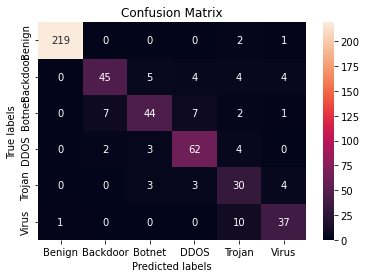

In [ ]:
import matplotlib.pyplot as plt     
import seaborn as sns
from sklearn import metrics

y_pred = modelRF.predict(XTest)

cm = metrics.confusion_matrix(yTest, y_pred)

ax= plt.subplot()
sns.heatmap(cm, annot = True, fmt = 'g', ax = ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Benign', 'Backdoor', 'Botnet', 'DDOS', 'Trojan', 'Virus']); 
ax.yaxis.set_ticklabels(['Benign', 'Backdoor', 'Botnet', 'DDOS', 'Trojan', 'Virus']);

print("\n\n\nAccuracy of the Model:", metrics.accuracy_score(yTest, y_pred))
print("\n\nClassification Report\n")
print(metrics.classification_report(yTest, y_pred))